A short investigation of the intermediate layerwise vectors and their cosine's correlation to human similarity score

In [1]:
import transformer_lens
from datasets import load_dataset
import torch
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
from sklearn.decomposition import PCA
import numpy as np

import torch.nn.functional as F

from tqdm import tqdm

import random

In [2]:
seed = 42
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

In [3]:
# Load datasets
train_set = load_dataset("sentence-transformers/stsb", split="train")
val_set   = load_dataset("sentence-transformers/stsb", split="validation")
test_set  = load_dataset("sentence-transformers/stsb", split="test")

def normalize(acts):
    return acts
    mean = acts.mean(keepdim=True, dim=-1)
    std = acts.std(keepdim=True, dim=-1)

    return (acts - mean) / std

first_train  = normalize(torch.load('gpt2_medium_train_acts_1.npy'))
second_train = normalize(torch.load('gpt2_medium_train_acts_2.npy'))

first_test = normalize(torch.load('gpt2_medium_test_acts_1.npy'))
second_test = normalize(torch.load('gpt2_medium_test_acts_2.npy'))

wikitext_acts = normalize(torch.load('generics_kb_10k_10272024.npy'))

train_scores = torch.Tensor(train_set['score'])
test_scores = torch.Tensor(test_set['score'])

 20%|███████████████████████████████████▏                                                                                                                                            | 10/50 [01:17<05:08,  7.71s/it]


Epoch 10
Train Losses - Early: 0.311, Mid: 1.434, Late: 14.974
Test Losses  - Early: 1.516, Mid: 5.705, Late: 33.321


 40%|██████████████████████████████████████████████████████████████████████▍                                                                                                         | 20/50 [02:33<03:46,  7.57s/it]


Epoch 20
Train Losses - Early: 0.241, Mid: 1.047, Late: 9.184
Test Losses  - Early: 1.396, Mid: 5.091, Late: 25.764


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 30/50 [03:49<02:31,  7.58s/it]


Epoch 30
Train Losses - Early: 0.201, Mid: 0.880, Late: 7.437
Test Losses  - Early: 1.345, Mid: 4.898, Late: 23.406


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 40/50 [05:05<01:16,  7.60s/it]


Epoch 40
Train Losses - Early: 0.170, Mid: 0.770, Late: 6.495
Test Losses  - Early: 1.324, Mid: 4.831, Late: 22.269


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [06:21<00:00,  7.62s/it]


Epoch 50
Train Losses - Early: 0.141, Mid: 0.682, Late: 5.800
Test Losses  - Early: 1.319, Mid: 4.772, Late: 21.595


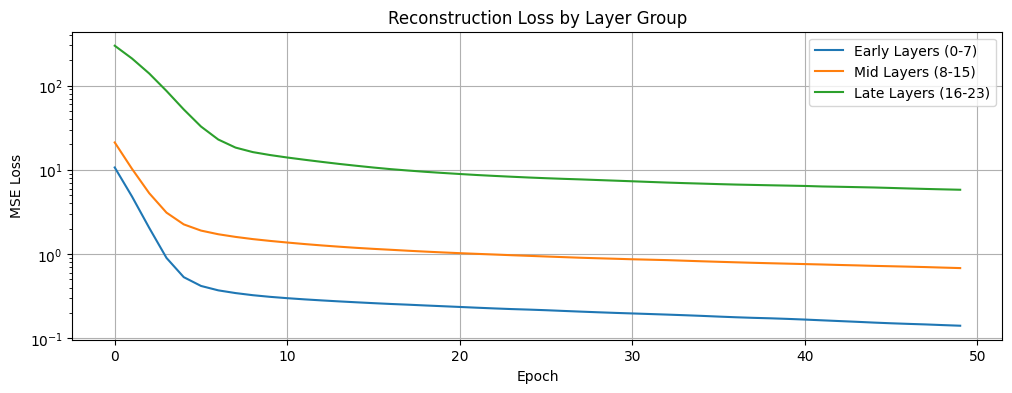

In [4]:
# We probably need to scale the hidden dimension based on how deep you are
def get_hidden(i):
    if i <= 12:
        return 1
    else:
        return 2

class Autoencoder(nn.Module):
    def __init__(self, layer_idx, d_in=1024, base_width=256):
        super().__init__()
        # Scale hidden dim based on layer position
        # Later layers get progressively larger capacity
        hidden_mult = get_hidden(layer_idx)
        d_hidden = int(base_width * hidden_mult)
        
        # Gradual dimension reduction
        d_mid = (d_in + d_hidden) // 2
        
        self.encode = nn.Sequential(
            nn.Linear(d_in, d_mid),
            nn.LayerNorm(d_mid),
            nn.GELU(),
            nn.Linear(d_mid, d_hidden),
            nn.LayerNorm(d_hidden),
            nn.GELU(),
            nn.Linear(d_hidden, d_hidden//2),
            nn.LayerNorm(d_hidden//2),
            nn.GELU(),
            nn.Linear(d_hidden//2, 128),
            nn.LayerNorm(128),
            nn.GELU(),
        )
        
        self.decode = nn.Sequential(
            nn.Linear(128, d_hidden),
            nn.LayerNorm(d_hidden),
            nn.GELU(),
            nn.Linear(d_hidden, d_mid),
            nn.LayerNorm(d_mid),
            nn.GELU(),
            nn.Linear(d_mid, d_in),
        )
        
        # Initialize with smaller weights for stability
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.5)
                
    def forward(self, x):
        h = self.encode(x)
        # Add residual connection for easier learning
        return self.decode(h)

n_layers = 24
# Create layer-specific autoencoders
autoencoders = [Autoencoder(i).cuda() for i in range(n_layers)]

# Use different learning rates for different layers
lrs = [3e-4 * (1 + i/24) for i in range(n_layers)]  # Higher lr for harder layers. From 3e-4 -> 3e-4*3
optimizers = [torch.optim.AdamW(ae.parameters(), lr=lr, weight_decay=0.01) for ae, lr in zip(autoencoders, lrs)]

# Modified training loop with layer-specific logging
def train_epoch(models, acts, optimizers, batch_size=64):
    losses = []
    n_batches = acts.shape[0] // batch_size
    
    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = (batch + 1) * batch_size
        
        batch_losses = []
        for i, (model, optimizer) in enumerate(zip(models, optimizers)):
            model.train()
            batch_i = acts[start_idx:end_idx, i].cuda()
            
            optimizer.zero_grad()
            loss = F.mse_loss(model(batch_i), batch_i)
            loss.backward()
            optimizer.step()
            
            batch_losses.append(loss.item())
        
        losses.append(batch_losses)
    
    return np.mean(losses, axis=0)

# Training with more detailed monitoring
early_layers_history = []
mid_layers_history = []
late_layers_history = []

all_acts = wikitext_acts
all_test_acts = torch.concat((first_test, second_test), axis=0)

for epoch in tqdm(range(50)):
    losses = train_epoch(autoencoders, all_acts, optimizers)
    
    # Track different layer groups
    early_layers_history.append(np.mean(losses[:8]))
    mid_layers_history.append(np.mean(losses[8:16]))
    late_layers_history.append(np.mean(losses[16:]))
    
    if (epoch+1) % 10 == 0:
        with torch.no_grad():
            [model.eval() for model in autoencoders]
            
            # Test losses by layer group
            test_preds = [autoencoders[i](all_test_acts[:, i].cuda()).cpu() for i in range(n_layers)]
            test_losses = [F.mse_loss(pred, all_test_acts[:, i]).item() for i, pred in enumerate(test_preds)]
            
            print(f"\nEpoch {epoch+1}")
            print(f"Train Losses - Early: {early_layers_history[-1]:.3f}, "
                  f"Mid: {mid_layers_history[-1]:.3f}, "
                  f"Late: {late_layers_history[-1]:.3f}")
            print(f"Test Losses  - Early: {np.mean(test_losses[:8]):.3f}, "
                  f"Mid: {np.mean(test_losses[8:16]):.3f}, "
                  f"Late: {np.mean(test_losses[16:]):.3f}")

# Plot training curves
plt.figure(figsize=(12, 4))
plt.plot(early_layers_history, label='Early Layers (0-7)')
plt.plot(mid_layers_history, label='Mid Layers (8-15)')
plt.plot(late_layers_history, label='Late Layers (16-23)')
plt.title('Reconstruction Loss by Layer Group')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()

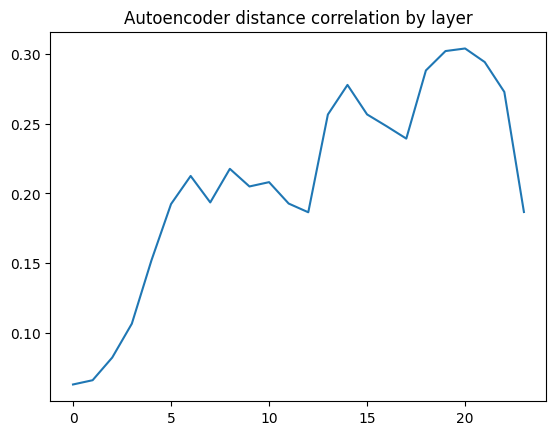

In [5]:
from copy import deepcopy
from torch.nn.functional import cosine_similarity

encoders = [deepcopy(ae.encode).cuda() for ae in autoencoders]
[m.eval() for m in encoders]

# Do a forward pass on each encoder for each pair of training sentences and collect the cosine distances
batch_size = 32
n_batches = first_test.shape[0] // batch_size

corrs = []
for l in range(n_layers):
    distances = []
    for i in range(n_batches+1):
        f = first_test[i*batch_size: (i+1)*batch_size, l,:]
        s = second_test[i*batch_size: (i+1)*batch_size, l, :]
    
        f_embed = encoders[l](f.cuda())
        s_embed = encoders[l](s.cuda())
    
        sims = cosine_similarity(f_embed, s_embed, dim=-1)
    
        distances.append(sims)

    corr = torch.corrcoef(torch.stack([torch.cat(distances).cpu(), test_scores]))[1][0]
    corrs.append(corr.item())

plt.title("Autoencoder distance correlation by layer")
plt.plot(corrs)

In [6]:
class SiameseNetwork(nn.Module):
    def __init__(self, mlp):
        super().__init__()
        self.mlp = mlp

    def forward(self, x1, x2):
        h1 = self.mlp(x1)
        h2 = self.mlp(x2)
        return F.cosine_similarity(h1, h2, dim=-1)

class LayerwiseSiameseNetworks(nn.Module):
    def __init__(self, encoders, n_layers=24, d_in=1024, d_hidden=256):
        super().__init__()
        self.n_layers = n_layers
        self.layer_nets = nn.ModuleList([SiameseNetwork(encoders[i]) for i in range(n_layers)])

    def forward(self, x1, x2):
        similarities = []
        for layer in range(self.n_layers):
            net_at_layer = self.layer_nets[layer].cuda()
            # Get the activations at the given layer
            x1_l = x1[:, layer].cuda()
            x2_l = x2[:, layer].cuda()

            sim_at_layer = net_at_layer(x1_l, x2_l)
            # print(sim_at_layer.shape)
            similarities.append(sim_at_layer)

        return torch.stack(similarities, dim=-1)

class SimilarityLearner(nn.Module):
    def __init__(self, encoders, n_layers=24, d_in=1024, d_hidden=256, d_out_hidden=512, dropout=0.1):
        super().__init__()
        self.layer_nets = LayerwiseSiameseNetworks(encoders, n_layers, d_in, d_hidden)

        self.mlp = nn.Sequential(
            nn.Linear(n_layers, d_out_hidden),
            nn.LayerNorm(d_out_hidden),
            nn.Dropout(dropout),  # Add dropout after normalization
            nn.GELU(),
            nn.Linear(d_out_hidden, d_out_hidden),
            nn.LayerNorm(d_out_hidden),
            nn.Dropout(dropout),  # Add dropout after normalization
            nn.GELU(),
            nn.Linear(d_out_hidden, d_out_hidden),
            nn.LayerNorm(d_out_hidden),
            nn.Dropout(dropout),  # Add dropout after normalization
            nn.GELU(),
            nn.Linear(d_out_hidden, 1),
            nn.Hardsigmoid()
        )

    def forward(self, x1, x2, training=True):
        layerwise_similarities = self.layer_nets(x1, x2)
        similarity = self.mlp(layerwise_similarities)
        return similarity.squeeze()

from copy import deepcopy
cloned_encoders = [deepcopy(e).encode for e in autoencoders]

similarity_learner = SimilarityLearner(cloned_encoders, d_hidden=512).to('cuda:0')
# similarity_learner = SimilarityLearner([Autoencoder(i) for i in range(24)], d_hidden=512).to('cuda:0')
optimizer = torch.optim.Adam(similarity_learner.parameters(), lr=3e-5)

def train_epoch(model, first_acts, second_acts, scores, optimizer, batch_size=32):
    model.train()
    total_loss = 0
    n_batches = first_acts.shape[0] // batch_size
    
    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = (batch + 1) * batch_size
        
        x1_batch = first_acts[start_idx:end_idx].cuda()
        x2_batch = second_acts[start_idx:end_idx].cuda()
        scores_batch = scores[start_idx:end_idx].cuda()
        
        optimizer.zero_grad()
        
        sims = model(x1_batch, x2_batch)
        
        loss = F.mse_loss(sims, scores_batch)        
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / n_batches

best_test_corr = 0
best_model = None

for epoch in tqdm(range(100)):
    # Training
    loss = train_epoch(similarity_learner, first_train, second_train, train_scores, optimizer)
    
    # Evaluation
    similarity_learner.eval()
    with torch.no_grad():
        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            # Get training correlations
            train_preds = similarity_learner(first_train.cuda(), second_train.cuda(), training=False)
            train_corr = torch.corrcoef(torch.stack([train_preds.cpu(), train_scores]))[0,1]
            
            # Get test correlations
            test_preds = similarity_learner(first_test.cuda(), second_test.cuda(), training=False)
            test_corr = torch.corrcoef(torch.stack([test_preds.cpu(), test_scores]))[0,1]

            # Test loss
            test_loss = F.mse_loss(test_preds.cpu(), test_scores)

            if test_corr > best_test_corr:
                best_test_corr = test_corr
                best_model = deepcopy(similarity_learner)

            print(f"Epoch {epoch+1}")
            print(f"Train Loss: {loss:.4f}")
            print(f"Test Loss: {test_loss:.4f}")
            print(f"Train correlation: {train_corr:.4f}")
            print(f"Test correlation: {test_corr:.4f}\n")

 10%|█████████████████▌                                                                                                                                                             | 10/100 [01:20<12:11,  8.13s/it]

Epoch 10
Train Loss: 0.0137
Test Loss: 0.0580
Train correlation: 0.9131
Test correlation: 0.6849



 20%|███████████████████████████████████                                                                                                                                            | 20/100 [02:41<10:51,  8.14s/it]

Epoch 20
Train Loss: 0.0076
Test Loss: 0.0490
Train correlation: 0.9534
Test correlation: 0.7070



 30%|████████████████████████████████████████████████████▌                                                                                                                          | 30/100 [04:02<09:30,  8.15s/it]

Epoch 30
Train Loss: 0.0037
Test Loss: 0.0540
Train correlation: 0.9453
Test correlation: 0.7129



 40%|██████████████████████████████████████████████████████████████████████                                                                                                         | 40/100 [05:23<08:09,  8.16s/it]

Epoch 40
Train Loss: 0.0032
Test Loss: 0.0516
Train correlation: 0.9642
Test correlation: 0.7193



 50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 50/100 [06:44<06:46,  8.13s/it]

Epoch 50
Train Loss: 0.0028
Test Loss: 0.0497
Train correlation: 0.9708
Test correlation: 0.7145



 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 60/100 [08:05<05:25,  8.13s/it]

Epoch 60
Train Loss: 0.0015
Test Loss: 0.0484
Train correlation: 0.9836
Test correlation: 0.7210



 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 70/100 [09:26<04:04,  8.15s/it]

Epoch 70
Train Loss: 0.0013
Test Loss: 0.0441
Train correlation: 0.9825
Test correlation: 0.7265



 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 80/100 [10:47<02:43,  8.15s/it]

Epoch 80
Train Loss: 0.0012
Test Loss: 0.0488
Train correlation: 0.9867
Test correlation: 0.7221



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 90/100 [12:08<01:21,  8.17s/it]

Epoch 90
Train Loss: 0.0008
Test Loss: 0.0445
Train correlation: 0.9910
Test correlation: 0.7323



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [13:28<00:00,  8.09s/it]

Epoch 100
Train Loss: 0.0010
Test Loss: 0.0441
Train correlation: 0.9916
Test correlation: 0.7261



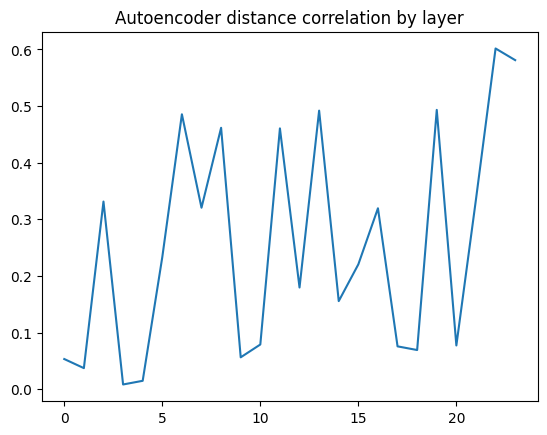

In [7]:
# Do a forward pass on each encoder for each pair of training sentences and collect the cosine distances
batch_size = 32
n_batches = first_test.shape[0] // batch_size

best_model.eval()
corrs = []
for l in range(n_layers):
    distances = []
    for i in range(n_batches+1):
        f = first_test[i*batch_size: (i+1)*batch_size]
        s = second_test[i*batch_size: (i+1)*batch_size]
        sims = best_model.layer_nets(f.cuda(), s.cuda())
    
        distances.append(sims[:, l])

    corr = torch.corrcoef(torch.stack([torch.cat(distances).cpu(), test_scores]))[1][0]
    corrs.append(corr.item())

plt.title("Autoencoder distance correlation by layer")
plt.plot(corrs)

In [8]:
norms = wikitext_acts.norm(dim=-1)
std = norms.var(dim=0)
mean = norms.mean(dim=0)

Text(0.5, 1.0, 'Standard deviation of activation norm over layers')

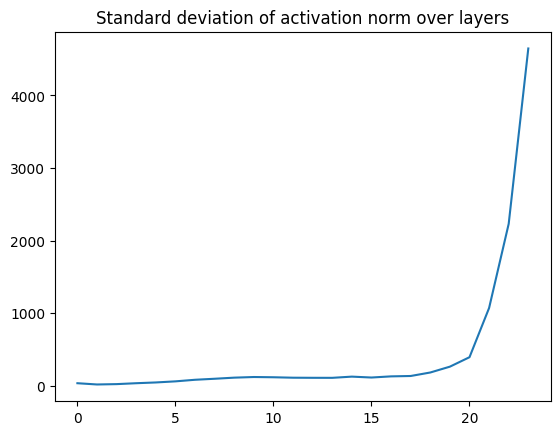

In [9]:
plt.plot(std)
plt.title("Standard deviation of activation norm over layers")

Text(0.5, 1.0, 'Mean activation norm over layers')

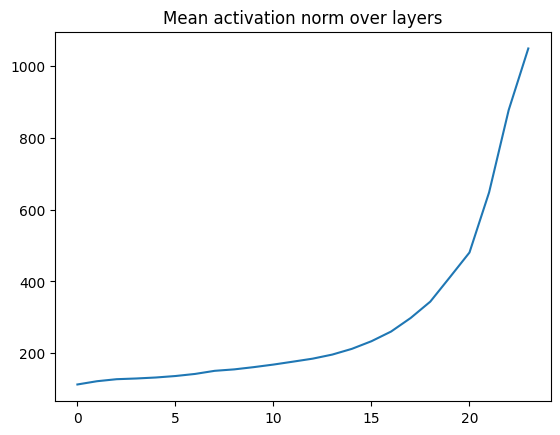

In [10]:
plt.plot(mean)
plt.title("Mean activation norm over layers")